# Processing DeWeirdt 2020

### Data Filters
1. pdna or etp > mean pdna -3 std
2. sgRNAs targetting essential genes
3. Match bin 1, tier 1 score of 0

In [1]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
import poola.core as pool

from core import add_transform_col

In [2]:
reads = pd.read_csv('../data/raw/DeWeirdt2020_Sp_S1.csv')
tp_genes = ['EEF2', 'HNRNPU', 'PELP1', 'TFRC', 'SF3B1', 'PSMA6', 'KPNB1', 'SNRPD1', 'RPS20', 'POLR1C']
fp_genes = ['CD81', 'CD33', 'FAS', 'ICAM1']

In [3]:
clean_reads = (reads.drop('Gene ID', axis=1)
               .drop_duplicates())
read_cols = ['pDNA_1', 'pDNA_2', 'A375_Dropout_Rep A', 'A375_Dropout_Rep B', 'MELJUSO_Dropout_Rep A',
             'MELJUSO_Dropout_Rep B', 'HT29_Dropout_Rep A', 'HT29_Dropout_Rep B']
lognorms = pool.lognorm_columns(reads_df=clean_reads, columns=read_cols)
filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['pDNA_1', 'pDNA_2'], z_low=-3)
print('pDNA Filtered: ' + str(lognorms.shape[0] - filtered_lognorms.shape[0]))

pDNA Filtered: 70


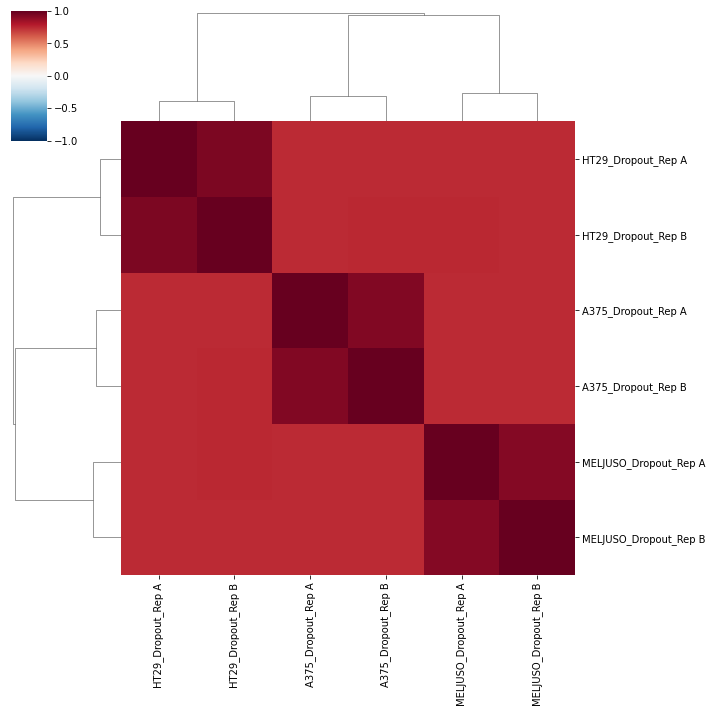

In [4]:
lfc_df = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_map={'A375_Dropout_Rep A': 'pDNA_1',
                                                                    'A375_Dropout_Rep B': 'pDNA_1',
                                                                    'MELJUSO_Dropout_Rep A': 'pDNA_2',
                                                                    'MELJUSO_Dropout_Rep B': 'pDNA_2',
                                                                    'HT29_Dropout_Rep A': 'pDNA_2',
                                                                    'HT29_Dropout_Rep B': 'pDNA_2'})
cors = lfc_df.corr()
sns.clustermap(cors, cmap='RdBu_r', vmin=-1, vmax=1)

In [5]:
long_cors = (cors.reset_index()
             .rename({'index': 'condition_rep1'}, axis=1)
             .melt(id_vars='condition_rep1',
                   var_name='condition_rep2', value_name='r'))
long_cors[['condition1', 'rep1']] = long_cors['condition_rep1'].str.split('_', expand=True)[[0, 2]]
long_cors[['condition2', 'rep2']] = long_cors['condition_rep2'].str.split('_', expand=True)[[0, 2]]
filtered_cors = long_cors[(long_cors['condition1'] == long_cors['condition2']) &
                          (long_cors['rep1'] != long_cors['rep2'])]
mean_pearson = filtered_cors['r'].mean()
print('Mean correlation: ' + str(round(mean_pearson, 4)))

Mean correlation: 0.93


In [6]:
sg_list = list(lfc_df['sgRNA sequence'].unique())
design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                            filters=[[('sgRNA Sequence', 'in', sg_list)]])

In [7]:
avg_replicate_lfc_df = pool.average_replicate_lfcs(lfcs=lfc_df, guide_col='sgRNA sequence', condition_indices=[0],
                                                   sep='_')

In [8]:
lfcs_designs = (avg_replicate_lfc_df.rename({'sgRNA sequence': 'sgRNA Sequence'}, axis=1)
                .merge(design_df, how = 'inner', on = 'sgRNA Sequence'))
roc_aucs, _ = pool.get_roc_aucs(lfcs=lfcs_designs, tp_genes=tp_genes,
                                fp_genes=fp_genes, gene_col='Target Gene Symbol',
                                score_col='avg_lfc', condition_col='condition')
roc_aucs

,condition,ROC-AUC
0,A375,0.931117
1,HT29,0.949948
2,MELJUSO,0.959593


In [9]:
roc_aucs['ROC-AUC'].mean()

0.9468858643390782

In [10]:
relevant_sgs_designs = lfcs_designs[lfcs_designs['Target Gene Symbol'].isin(tp_genes)]
filtered_sgs = relevant_sgs_designs[(relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0')].copy()
print('Off target filtered: ' + str(relevant_sgs_designs.shape[0] - filtered_sgs.shape[0]))

Off target filtered: 165


In [11]:
filtered_sgs['neg_lfc'] = -filtered_sgs['avg_lfc']
filtered_sgs = add_transform_col(df=filtered_sgs,
                                 col='neg_lfc',
                                 transform_name='yeo-johnson',
                                 transformed_name='scaled_neg_lfc',
                                 group_col=['Target Gene Symbol', 'condition'])
sg_avg_score = (filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol',
                                     'Target Cut %', 'On-Target Efficacy Score'])
                .agg({'scaled_neg_lfc': 'mean'})
                .reset_index())
sg_avg_score['scaled_neg_lfc'] = ((sg_avg_score['scaled_neg_lfc'] - sg_avg_score['scaled_neg_lfc'].mean())/
                                  sg_avg_score['scaled_neg_lfc'].std())

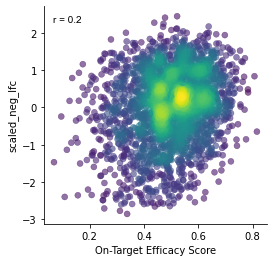

In [12]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=sg_avg_score, y='scaled_neg_lfc', x='On-Target Efficacy Score')
gpplot.add_correlation(data=sg_avg_score, y='scaled_neg_lfc', x='On-Target Efficacy Score')
sns.despine()

In [13]:
training_data = sg_avg_score.drop('On-Target Efficacy Score', axis=1)
training_data

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,scaled_neg_lfc
0,AAAAAATTATGCTGAATACC,GATTAAAAAATTATGCTGAATACCAGGTAG,KPNB1,75.6,-0.193618
1,AAAACAGGGGCACGAGGGTA,AGGAAAAACAGGGGCACGAGGGTATGGATA,HNRNPU,91.0,-0.203537
2,AAAACCGGCGCTGGAACCAC,GGTCAAAACCGGCGCTGGAACCACGGGACA,PSMA6,1.3,-0.823737
3,AAAACTATCAAGTTGGGATC,CCAAAAAACTATCAAGTTGGGATCAGGCAG,SF3B1,16.7,-0.559045
4,AAAACTCTTGGAGCAATATA,CCCAAAAACTCTTGGAGCAATATAAGGAAG,HNRNPU,80.5,1.277651
...,...,...,...,...,...
2398,TTTGGCAGCTGTGGGCTTAG,TTTGTTTGGCAGCTGTGGGCTTAGTGGGAG,KPNB1,76.7,-0.580166
2399,TTTGGCCATTGAAGCTTCAG,TGGATTTGGCCATTGAAGCTTCAGAGGTGA,KPNB1,33.9,-0.052899
2400,TTTGTATATAAATGCCTTAC,ATCTTTTGTATATAAATGCCTTACTGGGAT,HNRNPU,40.5,1.460837
2401,TTTGTCCAGGAAGTTGTCCA,ACAATTTGTCCAGGAAGTTGTCCAGGGCAG,EEF2,99.1,-1.252340


In [14]:
training_data.to_csv('../data/processed/DeWeirdt2020_activity.csv', index=False)